# Surface Image Segmentation 

## Imports

In [12]:
import numpy as np

from tqdm import tqdm
import glob

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [13]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
from torchvision import models

In [14]:
from torchvision.models.segmentation.fcn import _fcn_resnet
from torchgeo.models import resnet, resnet50

In [15]:
# Cluster
path = "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/"

In [16]:
!nvidia-smi

Tue Feb 14 21:12:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:B3:00.0 Off |                    0 |
| N/A   37C    P0    55W / 300W |  22733MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## U-Net Model - Base Model (NOT pre-trained)

In [18]:
# double convolutional layer which is executed in every step of the u-net 
# conv layer takes as input number of input channels -> in_channels and outputs vice versa
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # forward pass in the conv layer 
    def forward(self, x):
        return self.conv(x)

# design complete u-net shape 
# model takes as default 3 input channels and 6 output channels
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=6, features=[64, 128, 256, 512],  # features -> num of input nodes at every stage in the model 
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):  # reverse the features i.o. to move upwards in the model 
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # lowest stage in u-net 
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # final conv layer: takes in 64 channels and outputs 1 channel by default 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # forward pass of the u-net model between stages 
    def forward(self, x):
        skip_connections = []  # red arrows in the model representation 

        for down in self.downs:
            x = down(x)  # one DoubleConv run-through 
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [19]:
%%script echo skipping 
    
x = torch.randn((3, 1, 161, 161))
model = UNET(in_channels=1, out_channels=1)
print(model)
preds = model(x)
assert preds.shape == x.shape

skipping


## Dataset

In [20]:
imgs = glob.glob(path+'data/model_training/2_Ortho_RGB/sliced/*tif')
labels = glob.glob(path+'data/model_training/Labels_all/sliced/*tif')

# create dictionary -> {key: 'link/to/image_or_label'}
labels_dict = {label.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : label for label in labels}
imgs_dict = {img.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : img for img in imgs}

keys = sorted(list(set(imgs_dict)))

In [21]:
%%script echo skipping 

# check if keys in both dicts are the same 
print(set(imgs_dict) == set(labels_dict))

# inspect dicts
print(keys[:5])
print(labels_dict[keys[0]])
print(imgs_dict[keys[0]])

skipping


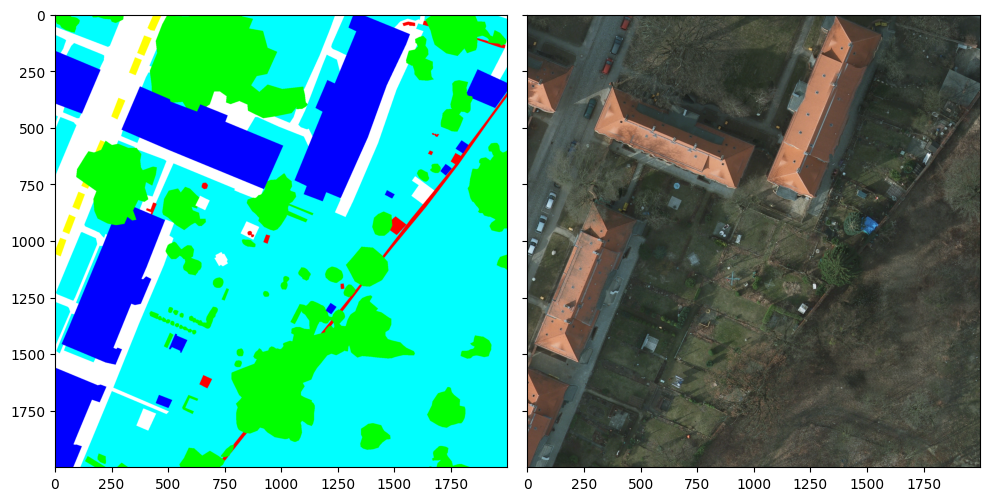

In [22]:
im1 = Image.open(labels_dict[keys[0]]).resize((2000, 2000))
im2 = Image.open(imgs_dict[keys[0]]).resize((2000, 2000))

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1) 
ax[1].imshow(im2) 

f.tight_layout()
plt.show()

- Impervious surfaces (RGB: 255, 255, 255)      | white 
- Building (RGB: 0, 0, 255)                     | blue 
- Low vegetation (RGB: 0, 255, 255)             | light-blue
- Tree (RGB: 0, 255, 0)                         | green            
- Car (RGB: 255, 255, 0)                        | yellow
- Clutter/background (RGB: 255, 0, 0)           | red

### Custom data set class

In [23]:
class PotsdamDataset(Dataset):
    def __init__(self, imgs_dict, labels_dict, keys, transform=None):
        self.img_dir = imgs_dict
        self.mask_dir = labels_dict
        self.keys = keys
        self.transform = transform
        
        self.RGB_classes = {
            'imprevious' : [255, 255, 225],
            'building' : [0,  0, 255],
            'low_vegetation' : [0, 255, 255],
            'tree' : [0,  255,  0], 
            'car' : [ 255, 255, 0],
            'background' : [255, 0, 0]
            }  # in RGB
        
        self.bin_classes = ['imprevious', 'building', 'low_vegetation', 'tree', 'car', 'background']

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_path = self.img_dir[self.keys[idx]]
        mask_path = self.mask_dir[self.keys[idx]]
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        
        cls_mask = np.zeros(mask.shape) # dim: (6000, 6000, 3)
        
        # Six to four classes: (imprevious + car + background) joined
        cls_mask[(mask == self.RGB_classes['imprevious']).all(-1)] = self.bin_classes.index('imprevious')
        cls_mask[(mask == self.RGB_classes['building']).all(-1)] = self.bin_classes.index('building')
        cls_mask[(mask == self.RGB_classes['low_vegetation']).all(-1)] = self.bin_classes.index('low_vegetation')
        cls_mask[(mask == self.RGB_classes['tree']).all(-1)] = self.bin_classes.index('tree')
        cls_mask[(mask == self.RGB_classes['car']).all(-1)] = self.bin_classes.index('imprevious')
        cls_mask[(mask == self.RGB_classes['background']).all(-1)] = self.bin_classes.index('imprevious')
        cls_mask = cls_mask[:,:,0] # omit last dimension (, , 3) -> RGB  

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=cls_mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

#### Testing the class

In [24]:
y = np.array(Image.open(labels_dict[keys[0]]))
x = np.zeros(y.shape)

RGB_classes = {
            'imprevious' : [255, 255, 225],
            'building' : [0,  0, 255],
            'low_vegetation' : [0, 255, 255],
            'tree' : [0,  255,  0], 
            'car' : [ 255, 255, 0],
            'background' : [255, 0, 0]
            }  # in RGB

bin_classes = ['imprevious', 'building', 'low_vegetation', 'tree', 'car', 'background']

x[(y == RGB_classes['imprevious']).all(-1)] = bin_classes.index('imprevious')
x[(y == RGB_classes['building']).all(-1)] = bin_classes.index('building')
x[(y == RGB_classes['low_vegetation']).all(-1)] = bin_classes.index('low_vegetation')
x[(y == RGB_classes['tree']).all(-1)] = bin_classes.index('tree')
x[(y == RGB_classes['car']).all(-1)] = bin_classes.index('car')
x[(y == RGB_classes['background']).all(-1)] = bin_classes.index('background')
x = x[:,:,0]

x[:15, :15]

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3.

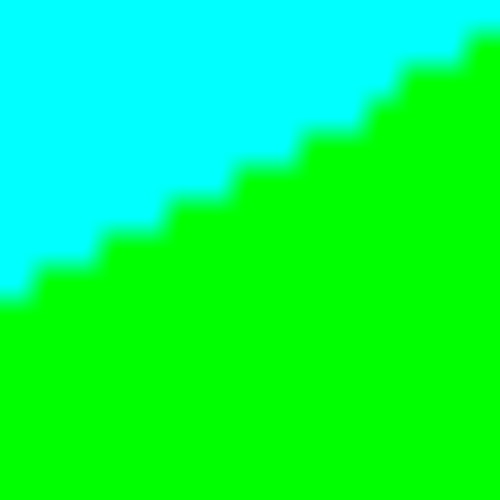

In [25]:
im = Image.open(labels_dict[keys[0]])
 
# Setting the points for cropped image
left = 0
top = 0
right = 15
bottom = 15

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
 
im1.resize((500, 500))

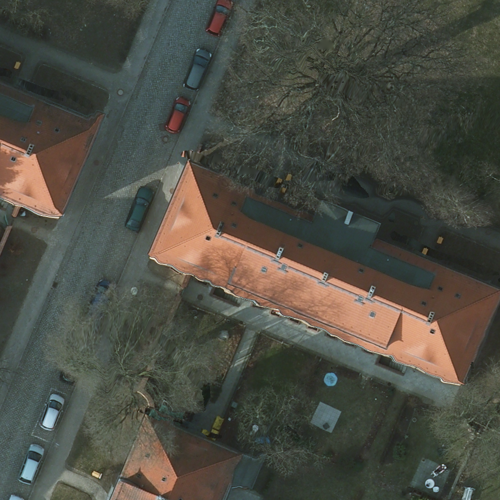

In [26]:
im = Image.open(imgs_dict[keys[0]])
 
# Setting the points for cropped image
left = 0
top = 0
right = 1000
bottom = 1000

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
im1.resize((500, 500))

## Utils 

### Train-/Test-Split

In [27]:
dataset = PotsdamDataset(imgs_dict, labels_dict, keys)
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

### Data Loader

In [28]:
def get_loaders(
    imgs_dict,
    labels_dict,
    keys,
    batch_size,
    train_transform,
    val_transform,
    num_workers = 2,
    pin_memory = True,
):
    
    train_data = PotsdamDataset(
        imgs_dict = imgs_dict,
        labels_dict = labels_dict,
        keys = keys, 
        transform = train_transform,
    )
    
    valid_data = PotsdamDataset(
        imgs_dict = imgs_dict,
        labels_dict = labels_dict,
        keys = keys, 
        transform = val_transform,
    )

    train_loader = DataLoader(
        train_data,
        batch_size = batch_size,
        num_workers = num_workers,
        pin_memory = pin_memory,
        sampler = train_sampler,
    )

    val_loader = DataLoader(
        valid_data,
        batch_size = batch_size,
        num_workers = num_workers,
        pin_memory = pin_memory,
        sampler = valid_sampler
    )

    return train_loader, val_loader

### Transform Functions

In [29]:
def build_transforms(image_heigt, image_width): 
    
    train_transform = A.Compose([
        #A.RandomCrop(
            #width=2000, 
            #height=2000, p=0.8),
        A.Resize(
            height=image_heigt, 
            width=image_width),
        A.Flip(p=0.5),
        A.ToGray(p=0.25),
        A.ColorJitter(p=0.25),
        #A.RandomShadow(
            #num_shadows_lower=1,
            #num_shadows_upper=3,
            #shadow_dimension=4,
            #p=0.25),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],)

    val_transform = A.Compose([
        A.Resize(height=image_heigt, width=image_width),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],)
    
    return train_transform, val_transform

### Evaluation Function 

In [30]:
def check_accuracy(loader, model, pretrained=False, device="cuda"):
    num_correct = 0
    num_pixels = 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            
            # compute probabilities
            if pretrained:
              probs = torch.nn.Softmax(model(x)['out'])
            else:
              probs = torch.nn.Softmax(model(x))
            
            # get predictions by choosing highest probability 
            preds = torch.argmax(probs.dim, axis=1).cpu()
            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} pixels correct with acc {num_correct/num_pixels*100:.2f}"
    )

### Save & Load Model

In [31]:
def save_checkpoint(state, filename="fine_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

## Training

In [32]:
# Specify number of classes for segmentation task
OUTPUT_CHANNELS = 4

### ResNet101: Pre-trained (ImageNet) - TorchVision

In [33]:
MODEL = models.segmentation.deeplabv3_resnet101(weights='DEFAULT')

In [34]:
# Freeze all layers but classification layer
for param in MODEL.parameters():
  param.requires_grad = False

MODEL.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
MODEL.aux_classifier = None

In [35]:
MODEL

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### ResNet50: Pre-trained (BigEarthNet) - Merge TorchGeo and TorchVision

Manas, O., Lacoste, A., Giró-i-Nieto, X., Vazquez, D., & Rodriguez, P. (2021). Seasonal contrast: Unsupervised pre-training from uncurated remote sensing data. In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 9414-9423).

**Notes**:

Citation 1: "... *SeCo pre-training is more effective for remote sensing tasks than the common ImageNet and MoCo pre-training.*"

Citation 2: "*The SeCo pipeline is composed of two parts. First, a principled procedure to gather large-scale, unlabeled and uncurated remote sensing datasets containing images from multiple Earth locations at different timestamps. Second, a self-supervised algorithm that takes advantage of time and position invariance to learn transferable representations for remote sensing applications.*"


In [36]:
# Load pre-trained weights of ResNet50 on BigEarthNet Data
# Input channels 3 (RGB) by default
weights_backbone = resnet.ResNet50_Weights.SENTINEL2_RGB_SECO

AttributeError: module 'torchgeo.models.resnet' has no attribute 'ResNet50_Weights'

In [37]:
# Define backbone ResNet50 - Classification Task
backbone = resnet50(weights=weights_backbone)

NameError: name 'weights_backbone' is not defined

In [ ]:
backbone

In [ ]:
# Transform the backbone classification ResNet50 in a segmentation fully-connected network
MODEL = _fcn_resnet(backbone, OUTPUT_CHANNELS, aux=False)

In [ ]:
MODEL

### Hyperparameters

In [46]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
NUM_EPOCHS = 2

DICT_IMGS = imgs_dict
LABELS_DICT = labels_dict
KEYS = keys
IMAGE_HEIGHT = 800  # 6000 originally
IMAGE_WIDTH = 800  # 6000 originally

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
PIN_MEMORY = True

LOAD_MODEL = False
PRETRAINED = True
GEO_PRETRAINED = False
FREEZE = True

OUTPUT_CHANNELS = 4

In [51]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    
  model.train()
  loss_sum = 0.0
  loop = tqdm(loader, desc="Training")
    
  for batch_idx, (data, targets) in enumerate(loop):
      
    data = data.to(device=DEVICE)
    targets = targets.type(torch.LongTensor).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
        if PRETRAINED or GEO_PRETRAINED:
          predictions = model(data)['out']
        else:
          predictions = model(data)

        loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    # comupte loss sum and count batches
    loss_sum += loss.item()
    batch_idx += 1

    # update loop every 10 batches
    if not batch_idx % 5:
      loop.set_postfix(loss=loss_sum/(batch_idx))


def main():
    
    train_transform, val_transform = build_transforms(
        image_heigt=IMAGE_HEIGHT, 
        image_width=IMAGE_WIDTH)

    train_loader, val_loader = get_loaders(
        DICT_IMGS, 
        LABELS_DICT,
        KEYS, 
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    # Load pre-trained DeepLapV3 ResNet101
    if PRETRAINED:
      MODEL = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
      MODEL.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
      MODEL.aux_classifier = None

    elif GEO_PRETRAINED:
      weights_backbone = resnet.ResNet50_Weights.SENTINEL2_RGB_SECO
      backbone = resnet50(weights=weights_backbone)
      MODEL = _fcn_resnet(backbone, OUTPUT_CHANNELS, aux=False)

    else: 
      MODEL = UNET(in_channels=3, out_channels=OUTPUT_CHANNELS)

    # Train only classifier (last layer)
    if PRETRAINED or GEO_PRETRAINED:
      if FREEZE:
        for name, param in MODEL.named_parameters():
          if "classifier" not in name:
            param.requires_grad = False
    
    MODEL = MODEL.to(device=DEVICE)

    # Class weights for multi-class classification
    # imprevious, building, low_vegetation, tree
    weights = [0.8, 0.1, 1.0, 1.0]
    class_weights = torch.FloatTensor(weights).cuda()

    CRITERION = nn.CrossEntropyLoss(weight = class_weights).to(device=DEVICE)
    OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)
    #SCHEDULER = optim.lr_scheduler.ExponentialLR(OPTIMIZER, gamma=0.1)

    if LOAD_MODEL:
        load_checkpoint(torch.load("love_checkpoint_DLV3.pth.tar"), MODEL)

    # check_accuracy(val_loader, model, device=DEVICE)
    SCALER = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        print(f"Start epoch: {epoch+1}")
        #print(f"Learning Rate: {SCHEDULER.get_last_lr()[0]}")
        
        # Train model
        train_fn(train_loader, MODEL, OPTIMIZER, CRITERION, SCALER)
        
        # adjust learning rate after training
        #SCHEDULER.step()
        
        # save model
        checkpoint = {
            "state_dict": MODEL.state_dict(),
            "optimizer": OPTIMIZER.state_dict(),
        }
        save_checkpoint(checkpoint)
        
        # check accuracy
        pre = PRETRAINED or GEO_PRETRAINED
        check_accuracy(val_loader, MODEL, pretrained=pre, device=DEVICE)
        
        print(f"End epoch: {epoch+1} \n")

In [52]:
# ResNet50 BigEarthNet - Train entire model
print(f"Cuda available: {torch.cuda.is_available()}")
main()

Cuda available: True
=> Loading checkpoint
Start epoch: 1


Training: 100%|██████████| 35/35 [02:02<00:00,  3.50s/it, loss=0.917]


=> Saving checkpoint
Got 29880778/43520000 pixels correct with acc 68.66
End epoch: 1 

Start epoch: 2


Training: 100%|██████████| 35/35 [01:46<00:00,  3.05s/it, loss=0.716]


=> Saving checkpoint
Got 30991813/43520000 pixels correct with acc 71.21
End epoch: 2 



## Predictions

In [53]:
def model_predict(image, model, dataset, image_height, image_width, pretrained=False, device="cuda", no_val_resize=False):

    img = np.array(image.convert("RGB"))

    # Convert image to tensor & transform
    _, val_transform = build_transforms(
        image_heigt=image_height, 
        image_width=image_width)
    
    if no_val_resize:
        val_transform.transforms.remove(val_transform.transforms[0])
    
    img = val_transform(image=img)
    pic = img['image']

    model.eval()
    with torch.no_grad():
        # Use image + pretend batch size of 1
        pic = pic.to(device).unsqueeze(0)

        # Compute probabilities
        if pretrained:
          probs = torch.nn.Softmax(model(pic)['out']).dim
        else:
          probs = torch.nn.Softmax(model(pic)).dim
        # Get predictions by choosing highest probability 
        preds = torch.argmax(probs, axis=1).cpu().squeeze(0)

        # Initialise empty arrays for RGB classes and RGB values
        classes = np.empty((preds.shape[0], preds.shape[1]), dtype="<S14")
        img_rgb = np.empty((preds.shape[0], preds.shape[1], 3))

        # Convert numeric labels to RGB classes
        for cl in dataset.bin_classes:
            classes[preds.detach().numpy() == dataset.bin_classes.index(cl)] = cl
            
        # Convert RGB classes to RGB values 
        for key, rgb in dataset.RGB_classes.items():
            img_rgb[classes == str.encode(key), :] = rgb

        return img_rgb.astype(int)

In [56]:
if PRETRAINED:
  trained_model = models.segmentation.deeplabv3_resnet101()

# More than last classifier layer

  trained_model.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
  trained_model.aux_classifier = None
  trained_model = trained_model.to(device='cuda')

  load_checkpoint(torch.load("fine_checkpoint.pth.tar"), trained_model)
  
else: 
  trained_model = UNET(in_channels=3, out_channels=4).to(device='cuda')
  load_checkpoint(torch.load("my_checkpoint.pth.tar"), trained_model)

=> Loading checkpoint


### Test 1

In [ ]:
size = 1000
img = Image.open(imgs_dict[keys[3]])
label = Image.open(labels_dict[keys[3]]).resize((size, size))

predictions = model_predict(
    image=img, 
    model=trained_model, 
    dataset=dataset, 
    image_height=size, 
    image_width=size)

predictions.shape

(1000, 1000, 3)

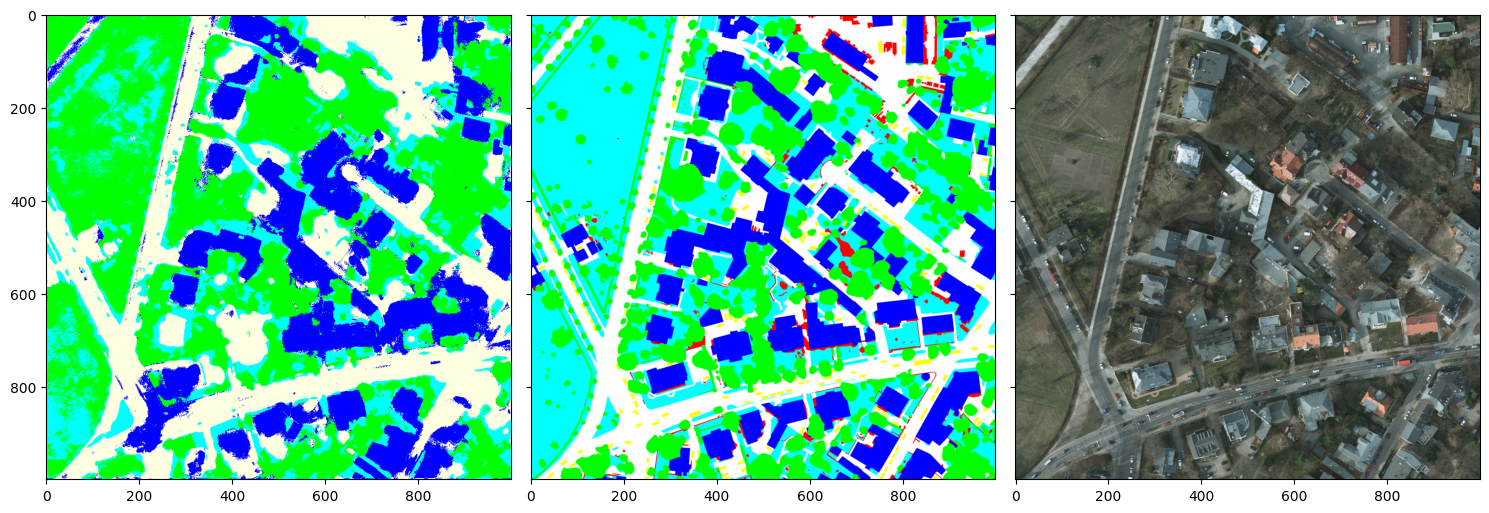

In [ ]:
im1 = predictions
im2 = label
im3 = img.resize((size, size))

f, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(im3)

f.tight_layout()
plt.show()

### Ear Prediction 1

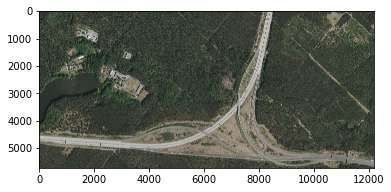

In [ ]:
input_img = Image.open(path+"BB_ML_0001_2017-06-02.jpg")

plt.imshow(input_img)
plt.show()

In [ ]:
img_arr = np.array(input_img.convert("RGB"))
img_arr.shape

(5710, 12200, 3)

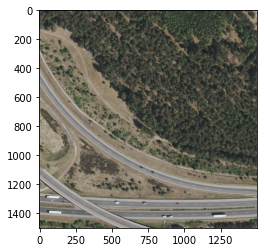

In [ ]:
# Setting the cordinates for cropped image
x_left = 8000
x_right = x_left + 1500

y_top = 4000
y_bottom = y_top + 1500

# Cropped image of above dimension
# (It will not change original image)
input_img_cropped = input_img.crop((x_left, y_top, x_right, y_bottom))

plt.imshow(input_img_cropped)
plt.show()

In [ ]:
size = 1500
predictions = model_predict(
    image=input_img_cropped, 
    model=trained_model, 
    dataset=dataset, 
    image_height=size, 
    image_width=size,
    pretrained=PRETRAINED)
predictions.shape

(1500, 1500, 3)

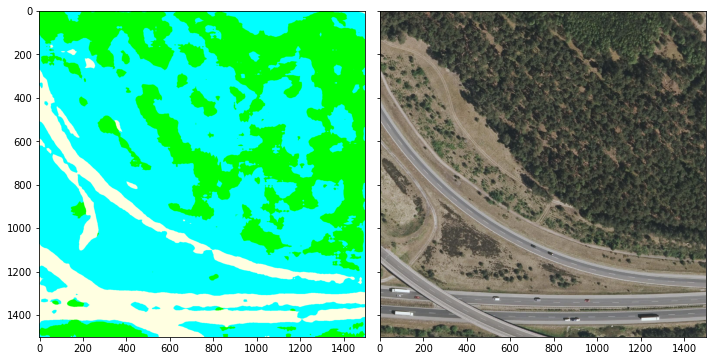

In [ ]:
# Acc 74 - weights = [0.9, 0.1, 0.9, 1.0]
im1 = predictions
im2 = input_img_cropped

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()

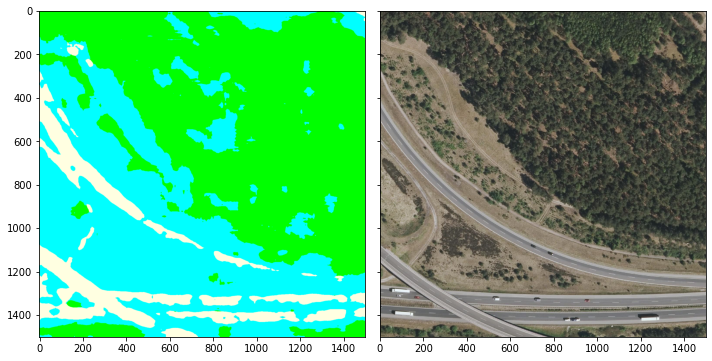

In [ ]:
# Acc 72
im1 = predictions
im2 = input_img_cropped

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()

### Ear Prediction 2

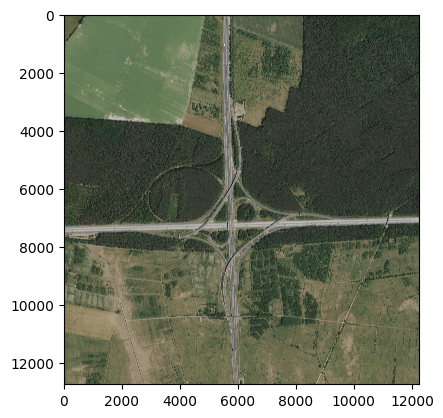

In [57]:
input_img = Image.open("/home/tu/tu_tu/tu_zxoau27/ds_project/model/data/BB_ML_0045_2017-06-02.jpg")

plt.imshow(input_img)
plt.show()

In [58]:
img_arr = np.array(input_img.convert("RGB"))
img_arr.shape

(12735, 12230, 3)

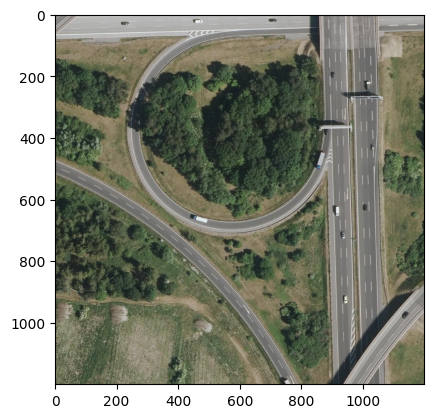

In [59]:
# Setting the cordinates for cropped image
x_left = 4800
x_right = x_left + 1200

y_top = 7300
y_bottom = y_top + 1200

# Cropped image of above dimension
# (It will not change original image)
input_img_cropped = input_img.crop((x_left, y_top, x_right, y_bottom))

plt.imshow(input_img_cropped)
plt.show()

In [66]:
size = IMAGE_HEIGHT
predictions = model_predict(
    image=input_img_cropped, 
    model=trained_model, 
    dataset=dataset, 
    image_height=size, 
    image_width=size,
    pretrained=PRETRAINED)
predictions.shape

(800, 800, 3)

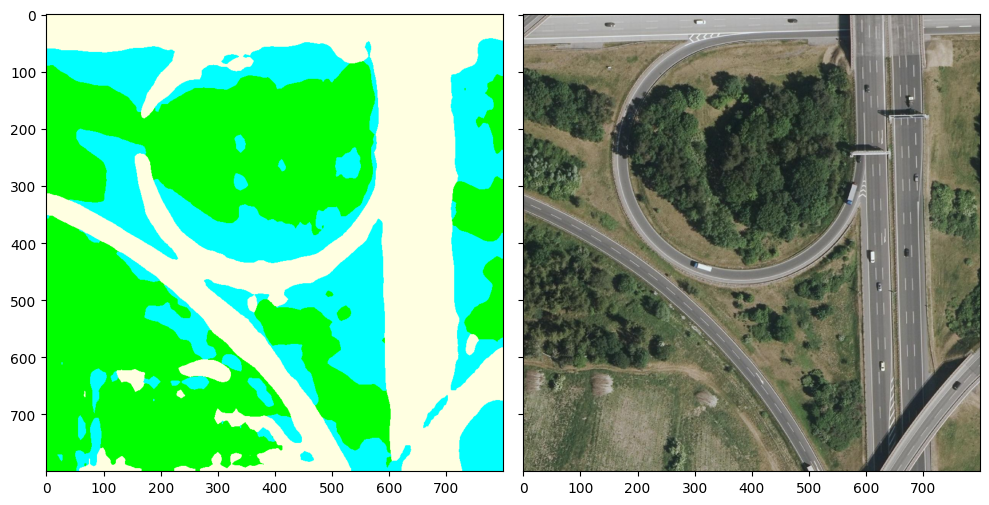

In [68]:
# Acc 74
im1 = predictions
im2 = input_img_cropped.resize((size, size))

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()

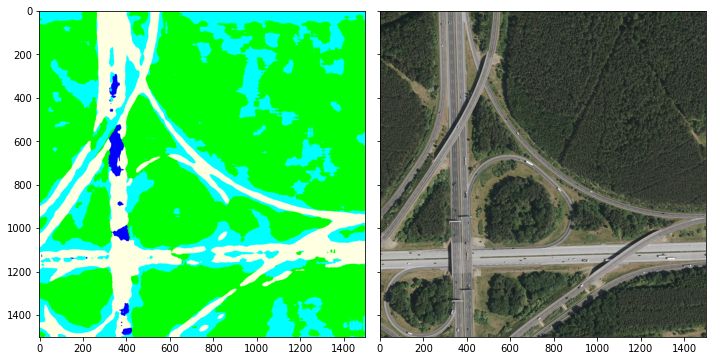

In [ ]:
# Acc 72
im1 = predictions
im2 = input_img_cropped

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()

### Ear Prediction 3

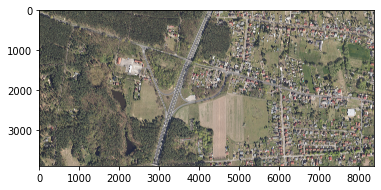

In [ ]:
input_img = Image.open(path+"BB_ML_0122_2016-05-02.jpg")

plt.imshow(input_img)
plt.show()

In [ ]:
img_arr = np.array(input_img.convert("RGB"))
img_arr.shape

(3895, 8390, 3)

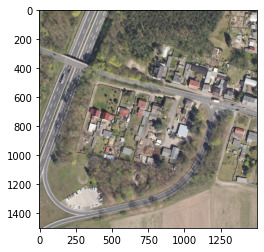

In [ ]:
# Setting the cordinates for cropped image
x_left = 3500
x_right = x_left + 1500

y_top = 900
y_bottom = y_top + 1500

# Cropped image of above dimension
# (It will not change original image)
input_img_cropped = input_img.crop((x_left, y_top, x_right, y_bottom))

plt.imshow(input_img_cropped)
plt.show()

In [ ]:
size = 3000
predictions = model_predict(
    image=input_img_cropped, 
    model=trained_model, 
    dataset=dataset, 
    image_height=size, 
    image_width=size,
    pretrained=PRETRAINED)
predictions.shape

(3000, 3000, 3)

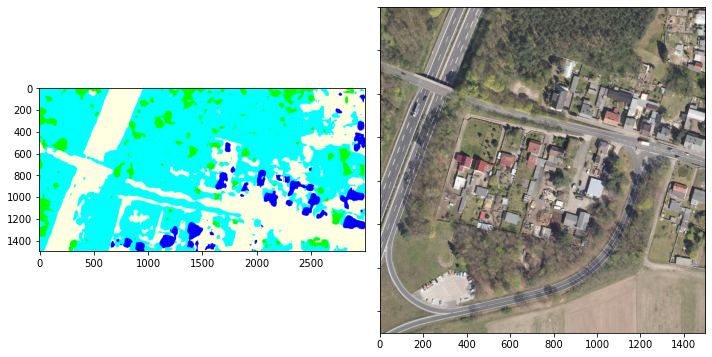

In [ ]:
# Acc 72
im1 = predictions
im2 = input_img_cropped

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()

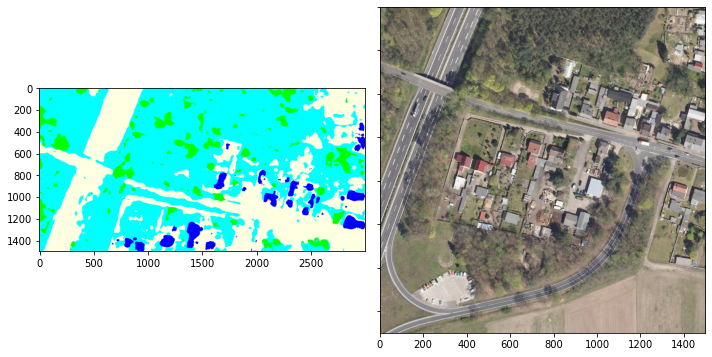

In [ ]:
# Acc 74
im1 = predictions
im2 = input_img_cropped

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()

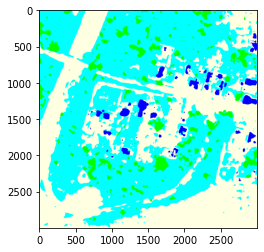

In [ ]:
plt.imshow(im1)